In [175]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

E = 1
I = 1
beam_length = 1
segment_count = 10
channel_height = 0.01
level_count = 3
Tx = -1000

c = channel_height / 2

s, ds = np.linspace(0, beam_length, segment_count, retstep=True)
possible_y = np.linspace(-c, c, level_count)

print(f"possible_configurations = level_count^segment_count = {level_count}^{segment_count} = {level_count**segment_count:.1e}")

possible_configurations = level_count^segment_count = 3^10 = 5.9e+04


In [176]:
def plot_beam(random_beam, s, c):
    plt.figure()
    plt.axhline(c, color='g')
    plt.axhline(-c, color='g')
    plt.plot(s, random_beam, marker='o')
    plt.grid()
    plt.show()

In [177]:
def configuration_energy(y, ds):
    v = 0
    for i in range(len(y) - 2):
        theta_i = np.arcsin((y[i+1] - y[i]) / ds)
        theta_i1 = np.arcsin((y[i+2] - y[i+1]) / ds)
        bending_energy = E * I * ((theta_i1 - theta_i) / ds)
        stretching_energy = Tx * (1 - np.cos(theta_i))
        v += bending_energy + stretching_energy
    return v

In [178]:
energies = []
beam_configurations = [np.array(beam_configuration) for beam_configuration in product(possible_y, repeat=segment_count)]

for beam_configuration in beam_configurations:
    energy = configuration_energy(beam_configuration, ds)
    energies.append(energy)

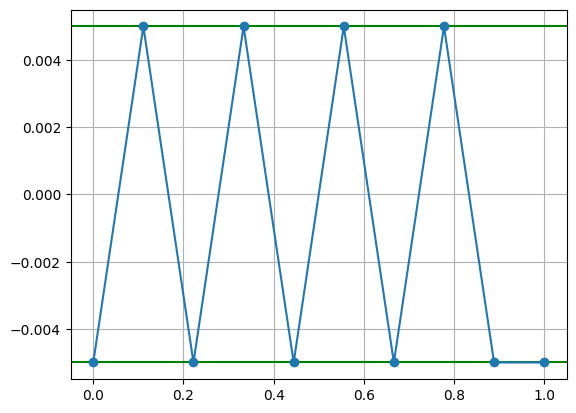

In [179]:
min_index = np.argmin(energies)
min_beam = beam_configurations[min_index]

plot_beam(min_beam, s, 0.005)

Best path (index pairs): [(1, 1), (1, 0), (0, 2), (2, 0), (0, 2), (2, 0), (0, 2), (2, 0), (0, 2), (2, 0)]
y-displacements: [np.float64(0.0), np.float64(0.0), np.float64(-0.005), np.float64(0.005), np.float64(-0.005), np.float64(0.005), np.float64(-0.005), np.float64(0.005), np.float64(-0.005), np.float64(0.005), np.float64(-0.005)]
Minimum energy: -0.013625254959801906


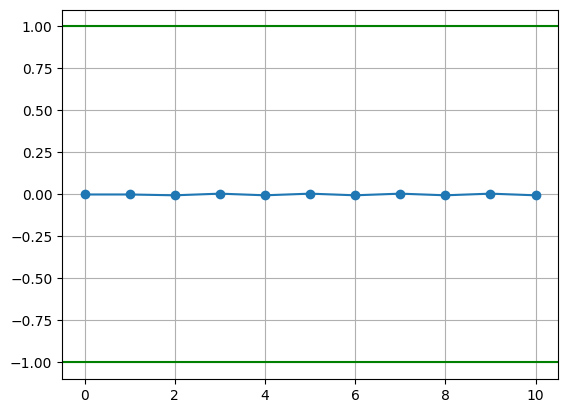

In [190]:
import numpy as np
import itertools

# Problem parameters
N = 10  # Number of beam segments
ds = 1.0
E = 1.0
I_beam = 1.0
Tx = -10

# Discrete vertical positions (can be changed to e.g. [-0.1, 0, 0.1])
# possible_y = [-1.0, 0.0, 1.0]
L = len(possible_y)
possible_y = np.linspace(-c, c, level_count)
Ib = np.where(np.isclose(possible_y, 0.0))[0][0]

# Energy function between two states (I,J) -> (J,K)
def g(state1, state2):
    I, J = state1
    _, K = state2
    try:
        theta1 = np.arcsin((J - I) / ds)
        theta2 = np.arcsin((K - J) / ds)
        bend = E * I_beam * ((theta2 - theta1) / ds)
        stretch = Tx * (1 - np.cos(theta1))
        return bend + stretch
    except ValueError:
        return np.inf  # arcsin domain error

# Initialization
C = {}
survivor = {}

for I, J in itertools.product(range(L), repeat=2):
    if I == J == Ib:
        C[(I, J, 1)] = 0
        survivor[(I, J, 1)] = [(I, J)]
    else:
        C[(I, J, 1)] = np.inf
        survivor[(I, J, 1)] = []

# Viterbi forward pass
for m in range(2, N+1):
    for J, K in itertools.product(range(L), repeat=2):
        best_cost = np.inf
        best_path = []
        for I in range(L):
            prev_state = (I, J, m-1)
            prev_cost = C.get(prev_state, np.inf)
            trans_cost = g((possible_y[I], possible_y[J]), (possible_y[J], possible_y[K]))
            total_cost = prev_cost + trans_cost
            if total_cost < best_cost:
                best_cost = total_cost
                best_path = survivor.get(prev_state, []) + [(J, K)]
        C[(J, K, m)] = best_cost
        survivor[(J, K, m)] = best_path

# Backtrace to find the optimal path
min_cost = np.inf
best_final = None
for key in C:
    if key[2] == N:
        if C[key] < min_cost:
            min_cost = C[key]
            best_final = key

best_path = survivor[best_final]

# Extract actual y-displacements
def extract_y_values_from_path(path):
    if not path:
        return []
    y_indices = [path[0][0], path[0][1]]
    for _, k in path[1:]:
        y_indices.append(k)
    return [possible_y[i] for i in y_indices]

y_displacements = extract_y_values_from_path(best_path)

# Output
print("Best path (index pairs):", best_path)
print("y-displacements:", y_displacements)
print("Minimum energy:", min_cost)

plot_beam(y_displacements, np.arange(0, len(y_displacements)*ds, ds), 1)